In [5]:
# wczytanie bibliotek

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from typing import NewType # dla czytelności kodu
matrix = NewType('3D-matrix', list[list[list[float]]])
array= NewType('numpy array', list) 

In [6]:
def mean_px_value_calc(index_col_start: int, index_col_stop: int,index_row_start: int, index_row_stop: int) -> array: 
    '''
    funkcja obliczająca średnią wartość dla piksela, mechanizm zainspirowany filtrami knwolucyjnymi
    
    argumenty funkcji to int określające pierwsze i ostatnie kolumny oraz wiersze macierzy filtru

    zwraca 2-wymiarową listę określającą średnią wartość r,g i b pikseli będących w sąsiedztwie danego piksela dla określonego odcinka krawędzi
    '''
    if index_row_start==index_row_stop: 
        return img[index_row_start,index_col_start:index_col_stop].mean(axis=0).round(2) 
    elif index_col_start==index_col_stop: 
        return img[index_row_start:index_row_stop,index_col_stop].mean(axis=0).round(2)
    else:
        return img[index_row_start:index_row_stop,index_col_start:index_col_stop].mean(axis=0).round(2).mean(axis=0) 

In [7]:


def mean_px_value_mapper(image: matrix, side: str, matrix_size: int=30) -> array :
    '''
    funkcja określająca wartości z jakimi należy wywołać funkcję obliczającą średnią,
    rozpatruje przypadki gdy macierz filtru wystaje z lewej, prawej dołu lub góry obrazu 
    oraz ten gdy mieści się ona w całości

    argumenty to obraz, na którym ma zostać przeprowadzona operacja (image), bok obrazu, który rozpatrujemy oraz rozmiar macierzy filtru

    zwraca 2-wymiarową listę określającą średnią wartość r,g i b pikseli będących w sąsiedztwie danego piksela tym razem już na całej długości krawędzi
    '''
    mean_px_value_list=[] 
    if side=="Top": 
        for i in range(-matrix_size,image.shape[1]):
            if i+matrix_size-1<matrix_size:
                mean_px_value_list.append(mean_px_value_calc(index_col_start=0, index_col_stop=i+matrix_size, index_row_start=0, index_row_stop=matrix_size)) 
            elif i+matrix_size-1>image.shape[0]:
                mean_px_value_list.append(mean_px_value_calc(index_col_start=i, index_col_stop=img.shape[1],index_row_start=0, index_row_stop=matrix_size))
            else:
                mean_px_value_list.append(mean_px_value_calc(index_col_start=i, index_col_stop=i+matrix_size ,index_row_start=0, index_row_stop=matrix_size))


    if side=="Bottom":
        for i in range(-matrix_size,image.shape[1]):
            if i+matrix_size-1<matrix_size:
                mean_px_value_list.append(mean_px_value_calc(index_col_start=0, index_col_stop=i+matrix_size, index_row_start=image.shape[1]-matrix_size, index_row_stop=image.shape[1]))
            elif i+matrix_size-1>image.shape[0]:
                mean_px_value_list.append(mean_px_value_calc(index_col_start=i, index_col_stop=img.shape[0],index_row_start=image.shape[1]-matrix_size, index_row_stop=image.shape[1]))
            else:
                mean_px_value_list.append(mean_px_value_calc(index_col_start=i, index_col_stop=i+matrix_size ,index_row_start=image.shape[1]-matrix_size, index_row_stop=image.shape[1]))

    if side=="Left":
        for i in range(-matrix_size,image.shape[0]):
            if i+matrix_size-1<matrix_size:
                mean_px_value_list.append(mean_px_value_calc(index_col_start=0, index_col_stop=matrix_size, index_row_start=0, index_row_stop=i+matrix_size))
            elif i+matrix_size-1>image.shape[0]:
                mean_px_value_list.append(mean_px_value_calc(index_col_start=0, index_col_stop=matrix_size,index_row_start=i, index_row_stop=image.shape[0]))
            else:
                mean_px_value_list.append(mean_px_value_calc(index_col_start=0, index_col_stop=matrix_size ,index_row_start=i, index_row_stop=i+matrix_size))

    if side=="Right":
        for i in range(-matrix_size,image.shape[0]):
            if i+matrix_size-1<matrix_size:
                mean_px_value_list.append(mean_px_value_calc(index_col_start=image.shape[0]-matrix_size, index_col_stop=image.shape[0], index_row_start=0, index_row_stop=i+matrix_size))
            elif i+matrix_size-1>image.shape[0]:
                mean_px_value_list.append(mean_px_value_calc(index_col_start=image.shape[0]-matrix_size, index_col_stop=image.shape[0],index_row_start=i, index_row_stop=image.shape[0]))
            else:
                mean_px_value_list.append(mean_px_value_calc(index_col_start=image.shape[0]-matrix_size, index_col_stop=image.shape[0] ,index_row_start=i, index_row_stop=i+matrix_size))    
    
    return np.asarray(mean_px_value_list[matrix_size:]) 

In [8]:
def gradient_maker(mean_px_value_list: array,ambi_range: int=30) -> array: 
    '''
    funkcja tworząca gradient między wartością średnią dla danego piksela a białością

    za argumenty przyjmuje listę średnich wartości pikseli wzdłuż danej krawędzi oraz "zasięg ambilight" (jak szeroki ma być gradient)

    zwraca 3 wymiarową listę reprezentującą gradient między średnią piksela a kolorem białym (kolor można zmienić modyfikując odpowiednio funkcję whites)
    '''
    whites=np.linspace(255,255,img.shape[0]*3,endpoint=True).reshape(img.shape[0],3) 
    gradient=np.linspace(mean_px_value_list,whites,ambi_range) 
    return gradient.astype("uint8")

In [9]:
def color_gradient(ambi_range: int=30,matrix_size=30)-> None:
    '''
    główna funkcja panująca nad całą resztą, jest to jedyna funkcja wywoływana bezpośrednio przez użytkownika
    powinna działać dla obrazów o dowolnym rozmiarze

    za argumenty przyjmuje wielkość macierzy filtru (łatwiej zmienić wartość przy wywołaniu tej niż grzebać w kodzie) oraz szerokość gradientu z analogicznej przyczyny

    funkcja nie zwraca nic, jedynie wyświetla finalny obraz
    '''

    top_gradient=gradient_maker(mean_px_value_list=mean_px_value_mapper(image=img, side="Top", matrix_size=matrix_size),ambi_range=ambi_range) 
    top_gradient=np.flip(top_gradient,axis=0)

    left_gradient=gradient_maker(mean_px_value_list=mean_px_value_mapper(image=img, side="Left", matrix_size=matrix_size),ambi_range=ambi_range).swapaxes(0,1) 
    left_gradient=np.flip(left_gradient,1)

    right_gradient=gradient_maker(mean_px_value_list=mean_px_value_mapper(image=img, side="Right", matrix_size=matrix_size),ambi_range=ambi_range).swapaxes(0,1)

    bottom_gradient=gradient_maker(mean_px_value_list=mean_px_value_mapper(image=img, side="Bottom", matrix_size=matrix_size),ambi_range=ambi_range)

    corners=np.linspace(255,255,ambi_range*ambi_range*3,endpoint=True).reshape(ambi_range,ambi_range,3)

    top=np.concatenate([corners,top_gradient,corners],axis=1)
    top=top.astype("uint8") 

    middle=np.concatenate([left_gradient,img,right_gradient],axis=1) 
    middle=middle.astype("uint8")

    bottom=np.concatenate([corners,bottom_gradient,corners],axis=1) 
    bottom=bottom.astype("uint8")

    final_image=np.concatenate([top,middle,bottom],axis=0) 
    final_image=final_image.astype("uint8")

    plt.imshow(final_image)

Tutaj się zaczyna 

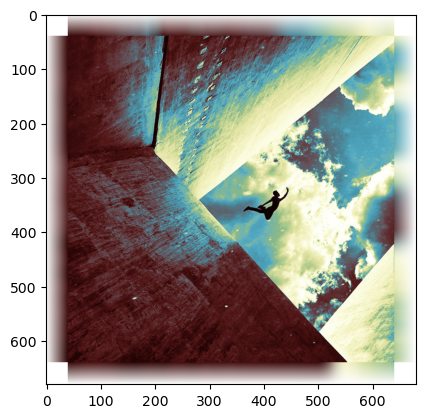

In [10]:
img=np.asarray(Image.open("test_image.jpeg"))
color_gradient(ambi_range=40,matrix_size=30)